In [124]:
from sklearn import linear_model
import pandas as pd
import numpy as np
from datetime import timedelta
import dash_core_components as dcc
import dash_daq as daq
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import dash_bootstrap_components as dbc
import dash_table
import dash
import plotly.express as px
from flask import Flask

def predict_next_fail(n, T, beta):
    lamb = n / (T**beta)
    lamb_hat = lamb * beta * T ** (beta-1)
    TTF = 1 / lamb_hat
    return TTF

def wrap_calc_beta(site):
    beta = []
    T0 = site.loc[0, 'Date'] 
    cumTTF = []
    failN = []
    deltT0 = site.loc[0, 'Cum Days']
    ind = 0
    for n, T in enumerate(site['Date']):
        cumTTF.append((T-T0).days+deltT0)
        failN.append(n+1)
        if ind == 0:
            beta.append(np.nan)
        else:
            beta.append(calc_beta(n, (T-T0).days+deltT0, cumTTF))
        ind += 1
    result = site[['Date', 'Equipment/Process', 
                   'Failure Mode', 'Contributing Factor', 'Klbs']].join(
                    pd.DataFrame.from_dict(({'Beta': np.round(beta,3), 
                    'Cumulative Days': cumTTF, 'Failure Number': failN})))
    result.Klbs = result.Klbs.round(2)
    result = result.fillna(value='None')
    return result

def make_crow_data(site_val = 'CHB', 
                 fail_type='All'):
    site = sites.loc[sites['Plant'].str.contains(site_val)]
    site = site.reset_index(drop=True)
    if fail_type == 'All':
        pass
    else:
        site = site.loc[site['Equipment/Process'] == fail_type].reset_index()
    result = wrap_calc_beta(site)
    return result

def make_scatter(result, y, log=False):
    fig = px.scatter(result, x='Cumulative Days', y=y, color='Equipment/Process', size='Klbs',
                    log_x=log, log_y=log)
    fig.update_layout(
                    height= 400)
    return fig

def calc_beta(n, T, cumTTF):
    return n / (n * np.log(T) - np.sum(np.log(cumTTF[:n])))

def find_peaks(result):
    # find peaks, 4-padded
    betas = result['Beta'].values[1:]
    peaks = np.zeros(len(betas)+1)
    peaks[5:-4][((betas[4:-4] - betas[3:-5] > 0) & 
     (betas[4:-4] - betas[2:-6] > 0) &
     (betas[4:-4] - betas[1:-7] > 0) &
     (betas[4:-4] - betas[0:-8] > 0) &
     (betas[4:-4] - betas[5:-3] > 0) & 
     (betas[4:-4] - betas[6:-2] > 0) &
     (betas[4:-4] - betas[7:-1] > 0) &
     (betas[4:-4] - betas[8:] > 0)) |
    ((betas[4:-4] - betas[3:-5] < 0) & 
     (betas[4:-4] - betas[2:-6] < 0) &
     (betas[4:-4] - betas[1:-7] < 0) &
     (betas[4:-4] - betas[0:-8] < 0) &
     (betas[4:-4] - betas[5:-3] < 0) & 
     (betas[4:-4] - betas[6:-2] < 0) &
     (betas[4:-4] - betas[7:-1] < 0) &
     (betas[4:-4] - betas[8:] < 0)) ] = 1
    peaks = np.argwhere(peaks).flatten()
    return peaks

In [125]:
# Load Data, Init Variables
sites = pd.read_csv("../crowamsaa_data.csv", parse_dates=['Date'])
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
site_vals = ['CHB', 'DEC', 'PEN']
fail_types = ['Equipment', 'Process', 'Equipment (Design)', 'All']
result = make_crow_data('CHB', 'All')
TTF = predict_next_fail(*result.loc[result.shape[0]-1, 
                        ['Failure Number', 'Cumulative Days', 'Beta']].values)
next_fail = result.iloc[-1,0] + timedelta(days=TTF)
result.Date = pd.DatetimeIndex(result.Date).strftime("%Y-%m-%d")
peaks = find_peaks(result)
result['Peak'] = False
result.iloc[peaks, -1] = True

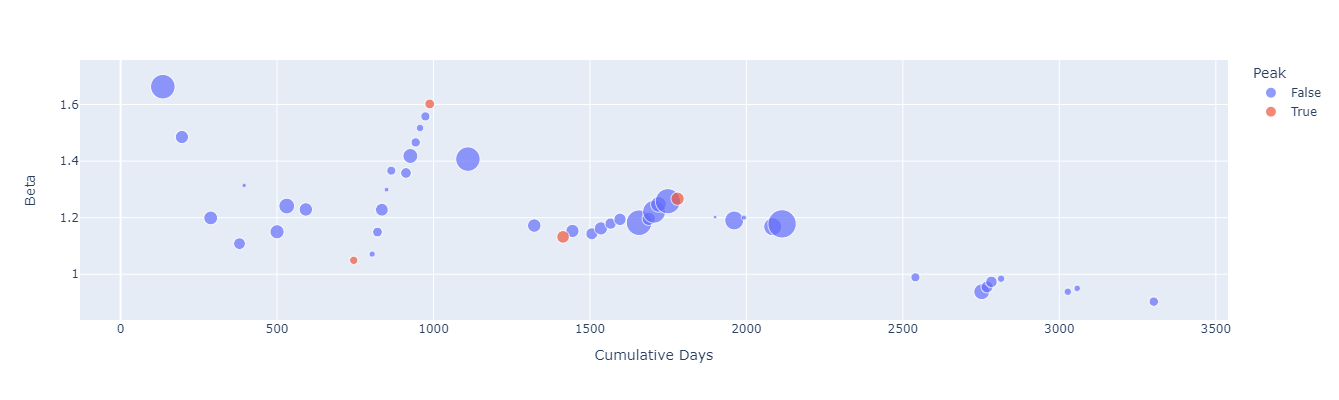

In [76]:
log = False
fig = px.scatter(result, x='Cumulative Days', y='Beta', color='Peak', size='Klbs',
                    log_x=log, log_y=log)
fig.update_layout(
                height= 400)

In [122]:
def make_scatter_with_regr(result, peaks):
    # plot len(peaks) + 1 linear models
    log = False
    fig = px.scatter(result, x='Cumulative Days', y='Failure Number', color='Peak', size='Klbs',
                        log_x=log, log_y=log)
    fig.update_layout(
                    height= 400)

    for i in range(len(peaks)+1):
        # define range, fit model

        model = linear_model.LinearRegression()
        if i == 0: # first seg
            segment = peaks[i]
            x = result.iloc[0:segment]['Cumulative Days'].values
            y = result.iloc[0:segment]['Failure Number'].values
        elif i == len(peaks): # last seg
            segment = peaks[i-1]
            x = result.iloc[segment:]['Cumulative Days'].values
            y = result.iloc[segment:]['Failure Number'].values
        else: # middle segs
            segment = peaks[i]
            x = result.iloc[old_segment:segment]['Cumulative Days'].values
            y = result.iloc[old_segment:segment]['Failure Number'].values
        model.fit(x.reshape(-1,1),y)

        # grab coefs, make line
        m = model.coef_[0]
        b = model.intercept_
        regrx = np.linspace(x[0], x[-1])
        regry = regrx*m+b

        old_segment = segment
        fig.add_trace(go.Scatter(x=regrx, y=regry,
                        mode='lines',
                        name=f'slope: {m:.3f}',
                            ))
    return fig

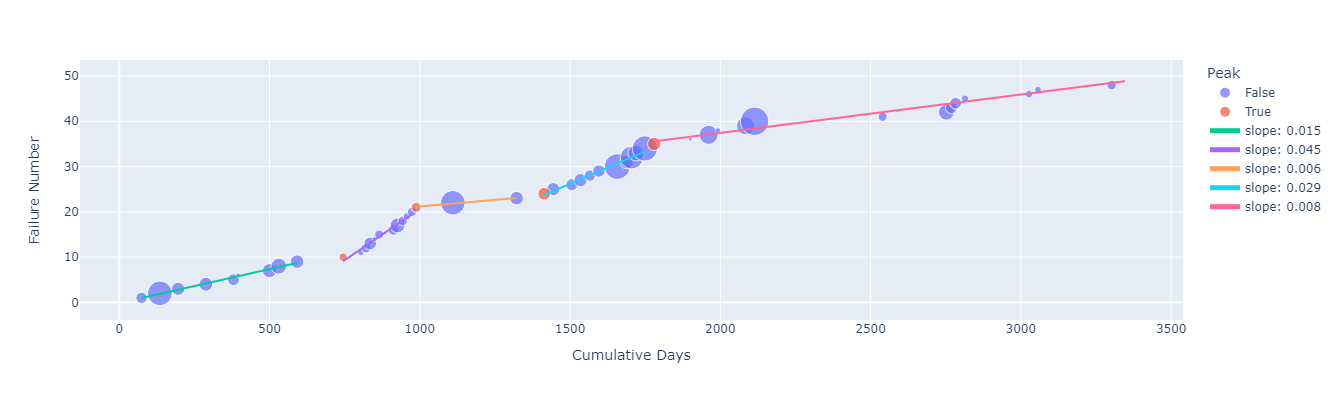

In [123]:
fig.show()

In [4]:
def update_plot(site, reason):
    result = make_crow_data(site, reason)
    TTF = predict_next_fail(*result.loc[result.shape[0]-1, 
                        ['Failure Number', 'Cumulative Days', 'Beta']].values)
    next_fail = result.iloc[-1,0] + timedelta(days=TTF)
    result.Date = pd.DatetimeIndex(result.Date).strftime("%Y-%m-%d")
    return [make_scatter(result, 'Beta', False),
            make_scatter(result, 'Failure Number', False),
           result.to_dict('records'),
           f"Next Failure: {next_fail.date()}"]

In [5]:
plots = update_plot('CHB', 'All')

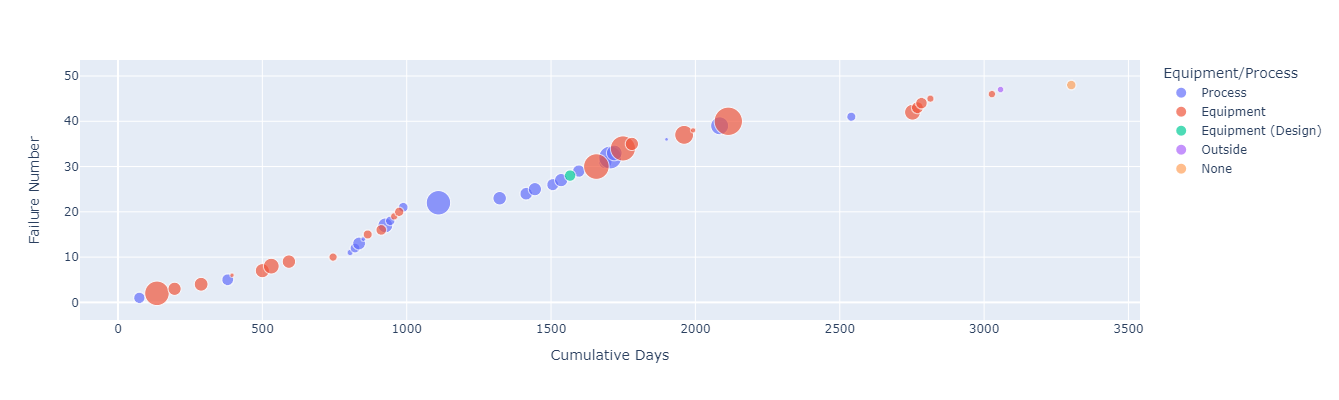

In [64]:
plots[1]